<a href="https://colab.research.google.com/github/pdrobny/MonReader/blob/main/TL_WnB_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import userdata
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import random
import wandb

from ast import Global
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, AvgPool2D, Conv2D, Flatten, Dense, Dropout, Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
# define a confusion matrix plotter for visualizing classification report results
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['flip', 'not flip']); ax.yaxis.set_ticklabels(['flip', 'not flip'])
    plt.show()

In [ ]:
# load files from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define configuration options
img_rows, img_cols = 224, 224
batch_size = 32
n_classes = 2
val_split = 0.2
verbosity = 1
path = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/training'
path_test = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/testing'
input_shape = (img_rows, img_cols, 3)
labels = ['flip', 'notflip']
seed = 42

In [ ]:

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

val_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = False,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = False,
    target_size=(img_rows, img_cols)
)


print("Train classes:", train_generator.class_indices)

# Compute class weights
y_train = train_generator.classes
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights_array))
print("Class weights:", class_weight)

Found 1238 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Train classes: {'flip': 0, 'notflip': 1}
Class weights: {0: np.float64(0.6655913978494624), 1: np.float64(2.00974025974026)}


In [ ]:
# print the length of the `train_generator`
print(len(train_generator))

39


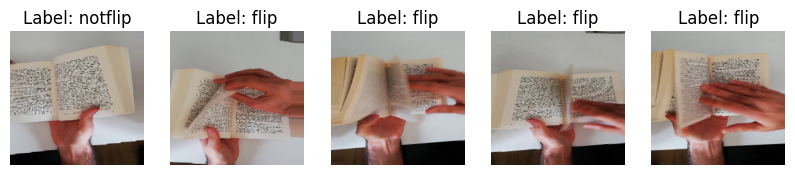

In [ ]:
# show random 5 training images
num_images_to_show = 5

# Get a batch from the training generator
images, labels = next(train_generator)

# Select random indices
random_indices = random.sample(range(len(images)), num_images_to_show)

# Map labels to class names
label_map = {v: k for k, v in train_generator.class_indices.items()}
selected_labels_names = [label_map[int(labels[idx])] for idx in random_indices]

# Display the selected images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Label: {selected_labels_names[i]}")
    plt.axis("off")
plt.show()

## Compile and run model

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pdrobny (pdrobny-dominicap-trading) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7962 - loss: 1.4669lr: 9.048374180359596e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - accuracy: 0.7982 - loss: 1.4460 - val_accuracy: 0.3472 - val_loss: 2.4505 - learning_rate: 1.0000e-04
Epoch 2/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.9375 - loss: 0.1328lr: 8.187307530779819e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 636ms/step - accuracy: 0.9375 - loss: 0.1328 - val_accuracy: 0.3889 - val_loss: 2.2574 - learning_rate: 9.0484e-05
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9656 - loss: 0.0844lr: 7.408182206817179e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9658 - loss: 0.0842 - val_accuracy: 0.3542 - val_loss: 3.4340 - learning_rate: 8.1873e-05
Epoch 4/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - accuracy: 0.9688 - loss: 0.0926lr: 6.703200460356394e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 527ms/step - accuracy: 0.9688 - loss: 0.0926 - val_acc

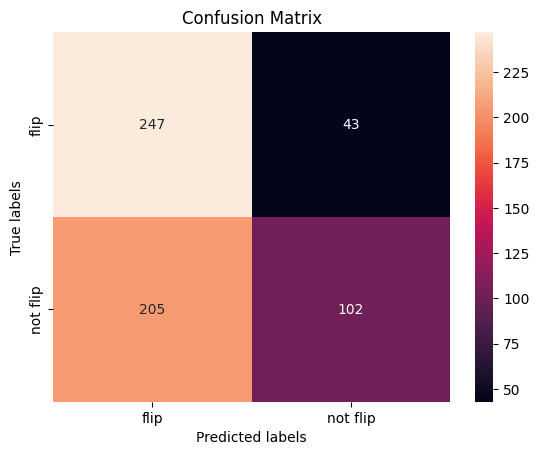

accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.97264
loss,0.06379
val_accuracy,0.40278
val_loss,2.25404


In [ ]:

# choose pre-trained model
model = MobileNetV2 #ResNet50 ,EfficientNetB0, MobileNetV2
model_name = model.__name__
optimizer = 'adam' # examples: 'adam', 'sgd', 'lion',
num_epochs = 5 # examples:5, 10, 15
batch = 32 # examples:  32, 64, 128
pooling_type = 'avg' # 'max' for MaxPooling2D, 'avg' for AvgPool2D
loss = 'binary_crossentropy' # examples: 'binary_crossentropy', 'categorical_crossentropy', 'mse', tfa.losses.SigmoidFocalCrossEntropy()
drop = 0.2
if pooling_type == 'max':
  pooling_layer = GlobalMaxPooling2D()
elif pooling_type == 'avg':
  pooling_layer = GlobalAveragePooling2D()
else:
  raise ValueError("pooling_type must be 'max' or 'avg'")

# Start a new wandb run to track this script.
run = wandb.init(
    project='fine-tuning',
    notes= model.__name__,
    config={
        'model_name': model_name,
        'optimizer': optimizer,
        'num_epochs': num_epochs,
        'batch': batch,
        'pooling_type': pooling_type,
        'loss': loss,
        'dropout': drop
    }
)
#load selected model
load_model = model(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)
#freeze layers
load_model.trainable = False

output = load_model.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(load_model.input, output)

# Build model
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(1, activation='sigmoid')) # Use 'sigmoid' for binary classification

model.compile(
    loss= loss,
    optimizer = optimizer,
    metrics=['accuracy']
)

# early stopping
checkpoint_path=f'flip_tlearn_{model_name}.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

# fit and train model
flip_model = model.fit(train_generator,
                                      steps_per_epoch=train_generator.samples // batch,
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=val_generator.samples // batch,
                                      callbacks=callbacks_list_,
                                      verbose=1)


 # Predict on test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)


# Final predictions
#y_pred = (y_pred_probs > best_thresh).astype(int).flatten()
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

#print(f"\n🔍 Best Threshold: {best_thresh:.2f}")
#print(f"✅ F1 Score: {best_f1:.4f}")
class_names = list(test_generator.class_indices.keys())
report_columns =  ["Class", "Precision", "Recall", "F1-score", "Support"]
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()).splitlines()


report_table = []
for line in class_report[2:(len(class_names)+2)]:
    report_table.append(line.split())
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

plot_confusion_matrix(y_true, y_pred)
# define target names and report columns
target_names = list(test_generator.class_indices.keys())
report_columns =  ["Class", "Precision", "Recall", "F1-score", "Support"]

# log metrics
wandb.log({'accuracy': flip_model.history['accuracy'][-1]})
wandb.log({'loss': flip_model.history['loss'][-1]})
wandb.log({'val_accuracy': flip_model.history['val_accuracy'][-1]})
wandb.log({'val_loss': flip_model.history['val_loss'][-1]})
wandb.log({'classification_report': wandb.Table(data=report_table, columns=report_columns)})
wandb.log({'Confusion Matrix' : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true, preds=y_pred,
                        class_names=target_names)})


# Finish the run
wandb.finish()

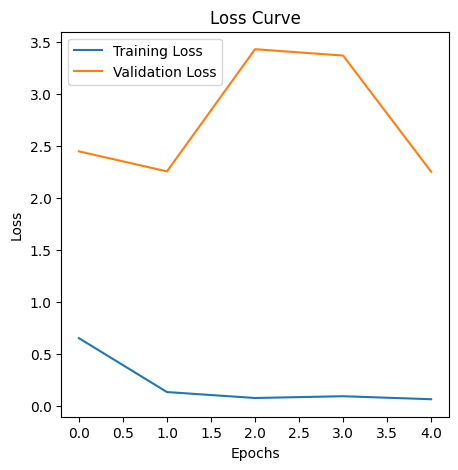

In [ ]:
# Plot loss curves for training and validation sets (flip_model)
history = flip_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

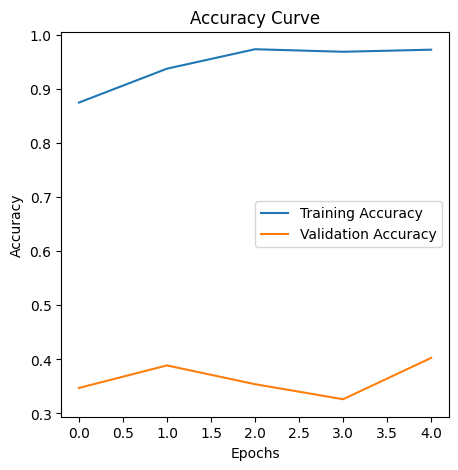

In [ ]:
## Plot accuracy curves for training and validation sets (flip_model)
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Shape of y_true: (32,)
Unique values in y_true: (array([0.], dtype=float32), array([32]))
Shape of predicted_classes: (32,)
Unique values in predicted_classes: (array([0, 1]), array([ 8, 24]))


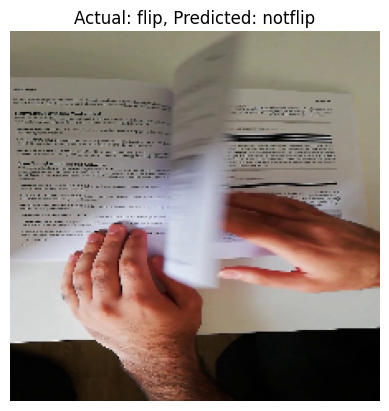

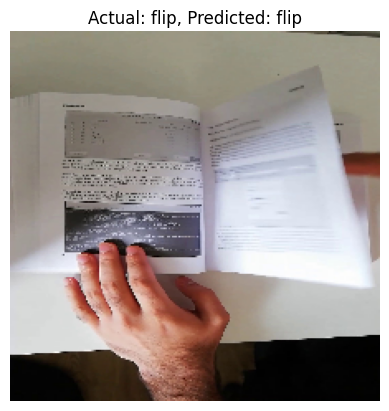

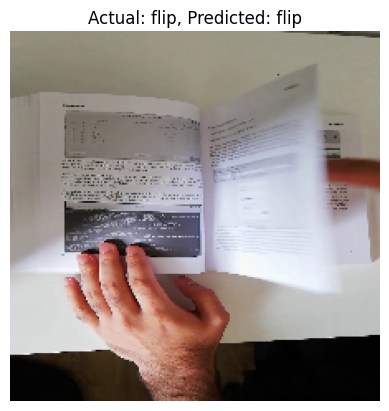

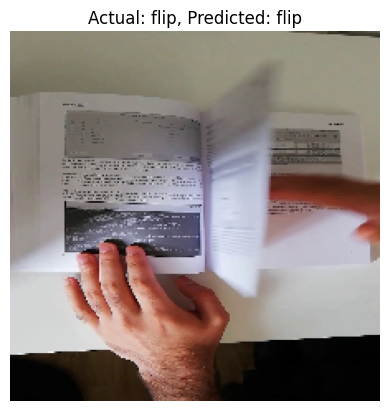

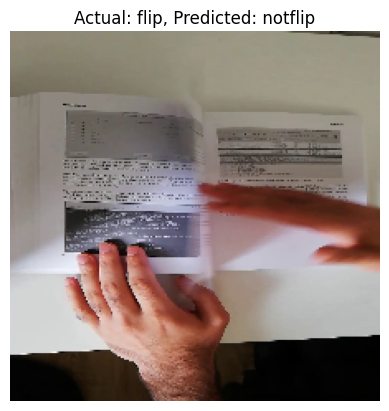

In [ ]:
# Predict on new data (example)
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)
predicted_classes = (predictions > 0.5).astype(int).flatten() # Flatten the predicted classes
y_true = sample_labels
class_names = list(test_generator.class_indices.keys())

# --- Debugging code ---
print("Shape of y_true:", y_true.shape)
print("Unique values in y_true:", np.unique(y_true, return_counts=True))
print("Shape of predicted_classes:", predicted_classes.shape)
print("Unique values in predicted_classes:", np.unique(predicted_classes, return_counts=True))
# --- End of debugging code ---

# Show some predicted images
for i in range(5):
    plt.imshow(sample_images[i])
    true_label = class_names[int(sample_labels[i])]
    predicted_label = 'flip' if predicted_classes[i] == 0 else 'notflip' # Access flattened array
    plt.title(f"Actual: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


## Fine-Tune Model

Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9855 - loss: 0.0411 - val_accuracy: 0.4062 - val_loss: 2.9221
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - accuracy: 1.0000 - loss: 0.0296 - val_accuracy: 0.4444 - val_loss: 2.7387
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.9814 - loss: 0.0446 - val_accuracy: 0.4167 - val_loss: 2.7264
Epoch 9/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 955ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.4062 - val_loss: 2.7831
Epoch 10/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.9907 - loss: 0.0238 - val_accuracy: 0.4097 - val_loss: 2.9644
Epoch 11/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 954ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 0.4271 - val_loss: 3.1245
Epoch 12/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 0.3750 - val_loss: 3.5628
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
              precision    recall  f1-score   support

        

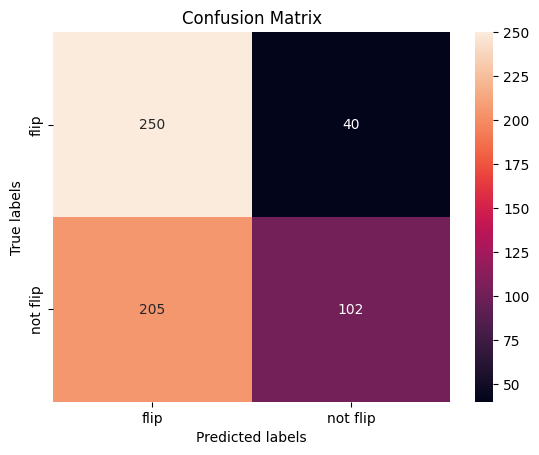

final_accuracy,▁
final_loss,▁
final_val_accuracy,▁
final_val_loss,▁
final_accuracy,0.99254
final_loss,0.02345
final_val_accuracy,0.375
final_val_loss,3.56277


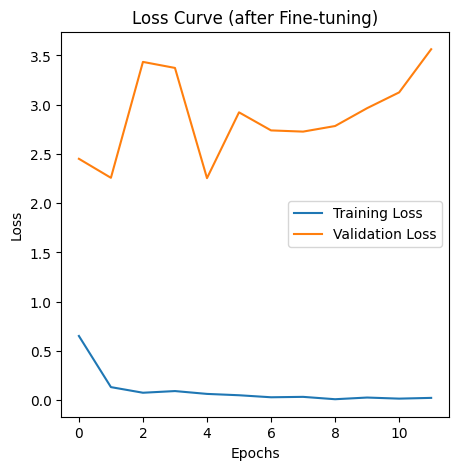

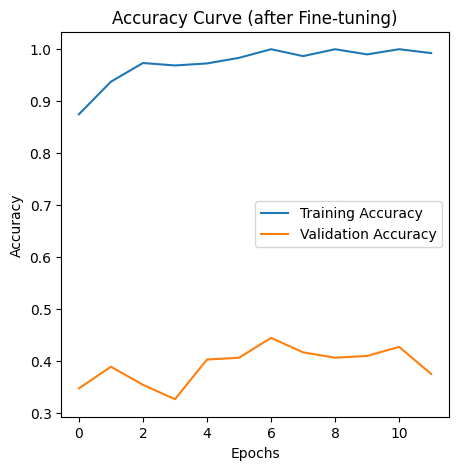

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


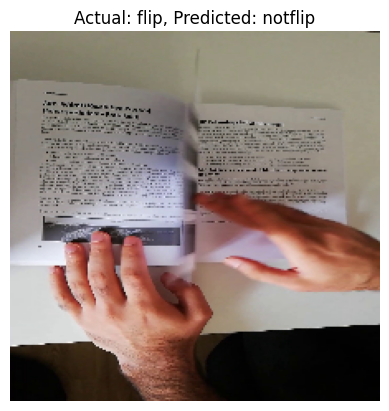

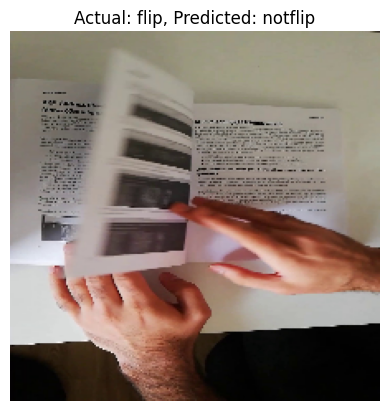

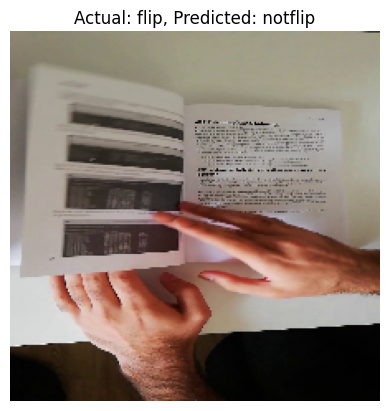

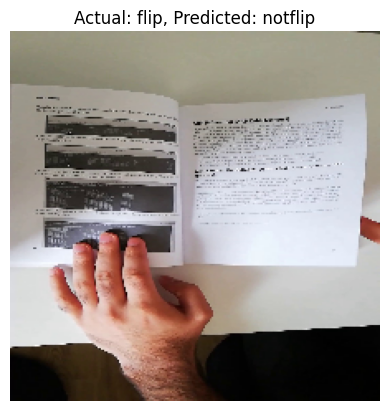

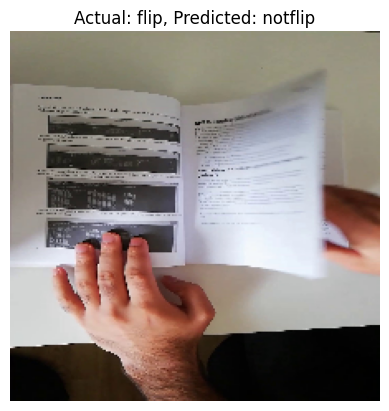

In [ ]:
# fine tune model
lrate = 1e-5 # Lower learning rate for fine-tuning

# Start a new wandb run to track this script.
run = wandb.init(
    project='Fine-tuning',
    notes= 'fine-tuned_'+ model_name,
    config={
        'model_name': model_name,
        'optimizer': optimizer,
        'num_epochs': num_epochs,
        'batch': batch,
        'pooling_type': pooling_type, # Added comma here
        'lr': lrate
    }
)
# Unfreeze layers for fine-tuning
basemodel.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(lrate),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 10 # Example number of epochs for fine-tuning
total_epochs = num_epochs + fine_tune_epochs

fine_tune_history = model.fit(train_generator,
                              steps_per_epoch=train_generator.samples // batch_size,
                              epochs=total_epochs,
                              initial_epoch=flip_model.epoch[-1] + 1,  # Start from the epoch where previous training ended
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // batch_size,
                              callbacks=keras_callbacks, # Use the same callbacks or define new ones
                              verbose=1)

# Combine histories for plotting
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])

# Continue with prediction and evaluation after fine-tuning
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # Assuming 0.5 is still the threshold

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
plot_confusion_matrix(y_true, y_pred)

# Update wandb logs with final results after fine-tuning
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()).splitlines()
report_table = []
for line in class_report[2:(len(class_names)+2)]:
    report_table.append(line.split())

wandb.log({'final_accuracy': history.history['accuracy'][-1]})
wandb.log({'final_loss': history.history['loss'][-1]})
wandb.log({'final_val_accuracy': history.history['val_accuracy'][-1]})
wandb.log({'final_val_loss': history.history['val_loss'][-1]})
wandb.log({'final_classification_report': wandb.Table(data=report_table, columns=report_columns)})
wandb.log({'Final Confusion Matrix' : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true, preds=y_pred,
                        class_names=target_names)})

# Finish the run
wandb.finish()

# Plot combined loss curves
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (after Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot combined accuracy curves
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (after Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict on new data (example) after fine-tuning
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()
y_true = sample_labels
class_names = list(test_generator.class_indices.keys())

# Show some predicted images after fine-tuning
for i in range(5):
    plt.imshow(sample_images[i])
    true_label = class_names[int(sample_labels[i])]
    predicted_label = 'flip' if predicted_classes[i] == 0 else 'notflip'
    plt.title(f"Actual: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()